<a href="https://colab.research.google.com/github/keyboardsmashing/Dropbox/blob/main/2_Coral_Reef_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning with coral reef soundscape data**

This notebook details the audio analysis performed for the paper [Title ex: "Soundscapes of Coral Reef"].

 [https://colab.research.google.com/drive/13yWRjp9b-9KZS33yC3nuPW7N10yFATLt#scrollTo=Rp2afetqTiIZ]

If you use any of these methods after reading this then please cite the article.

"This publication combinines pretrained neural networks with unsupervised learning to analyse soundscape ecology."

It builds on this notebook detailing the feature extraction necessary for the following analysis, available at this link.

What this notebook does:
1. Use UMAP to explore data qualitatively.
2. Use UMAP to reduce dimensions of data and then train an unsupervised clustering algorithm to explore data quantitatively.
3. Use PCA to reduce dimensions and explore data qualitatively.

Next steps:
Consult the R -based mixed effects model illustrating the explanatory power of class (habitat type), site, and recorder ID on UMAP dimensions.






# **Step 1: Set up**

To begin, we mount our Google Drive.

In [ ]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


"## Install UMAP
UMAP is not a standard package on Colab so we start by installing it. This is typically using the terminal. We can use an '!' before code to run it as a terminal command."

In [ ]:
#Install UMAP
!pip install umap-learn
import umap

In [ ]:
#Install hdbscan package
!pip install hdbscan
from sklearn.datasets import make_blobs
import hdbscan

from sklearn.metrics import silhouette_score #Import silhouette scores
from sklearn.decomposition import PCA #Import PCA packages
from sklearn.preprocessing import StandardScaler #Import PCA packages

In [ ]:
import scipy.cluster.hierarchy as sch #For dendogram


In [ ]:
#@title Import packages
import os # for handling files and directories
import librosa # for audio processing
import tensorflow as tf # for machine learning
import tensorflow_hub as hub # for machine learning
import numpy as np # for numerical processing
import pandas as pd # for handling dataframes
from tqdm import tqdm # for progress bar
import matplotlib.pyplot as plt # for potting
from sklearn.cluster import KMeans # for clustering
import seaborn as sns
# To get reproducible results, we set the seed
random_seed = 0

In [ ]:
#Paste into above textbox after this test
from sklearn.cluster import AffinityPropagation # for clustering


In [ ]:
#@title Set all filepaths based on the input data ad the files we will create

#Path where the csv of extracted features was saved
feature_df_path = '/content/drive/MyDrive/UCL /Dissertation coral Bioacoustics/full_extracted_features.csv'

#Path where we will save the full features data drame, features_df, with added metadata
features_metadata_path = '/content/drive/MyDrive/UCL /Dissertation coral Bioacoustics/metadata_feature_embeddings_full.csv'

#Path where we will save cluster results
cluster_results_path = '/content/drive/MyDrive/UCL /Dissertation coral Bioacoustics/cluster_results_full.csv'

#Path where we will save the full features data drame, features_df, with added metadata
features_metadata_umap_path = '/content/drive/MyDrive/UCL /features_metadata_umap.csv'


### Take a peek at the features dataframe

Check it looks in order. Note each file was split into 5s samples, so we have the added 'embedding_index' column which denotes which sample of a longer file this row pertains to, e.g for a 60s file there will be 12 rows.

In [ ]:
#Load the saved csv from gdrive as a dataframe
features_df = pd.read_csv(feature_df_path)

features_df

,filename,embedding_index,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_1270,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279
0,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,1,-0.002539,0.083185,0.222650,0.004583,0.038043,0.017060,-0.051531,0.048980,...,-0.026595,-0.078421,0.141446,-0.028569,0.053492,0.003565,0.013917,0.010823,0.028640,0.045186
1,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,2,0.046627,0.109666,0.282049,-0.077606,0.367022,-0.025223,0.031093,0.117443,...,-0.029934,0.014744,0.191568,0.086299,0.063188,0.010785,0.108753,0.066897,0.031906,0.045598
2,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,3,-0.010742,0.172192,0.392482,-0.095805,0.209476,-0.028116,0.007652,0.027511,...,-0.036542,-0.003506,0.110579,-0.000310,0.081100,-0.001886,0.072354,0.053671,0.115199,0.052882
3,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,4,-0.044842,0.186239,0.366160,-0.096586,0.203667,-0.036239,0.058365,0.119342,...,-0.034858,-0.014681,0.079934,0.067377,0.009581,0.008874,0.114696,0.039663,0.026609,0.054825
4,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,5,-0.023756,0.180806,0.452852,-0.080918,0.123796,-0.041198,-0.057296,0.180241,...,-0.028202,-0.103154,0.003755,0.222628,0.040353,0.021912,0.417833,0.107317,0.121505,0.032021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17045,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,7,-0.029924,0.020315,0.122832,-0.105937,0.066880,0.018540,-0.031619,0.003219,...,-0.031646,-0.054069,-0.040042,0.046798,0.047721,0.021873,-0.093131,0.038579,0.031557,0.051119
17046,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,8,-0.020249,0.044725,0.071765,-0.071905,0.006452,0.074069,0.099389,-0.061598,...,-0.034972,-0.111570,0.032762,0.104740,-0.010674,0.021865,-0.071306,0.001389,-0.019429,0.020112
17047,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,9,-0.008965,-0.014248,0.042899,-0.086784,0.069233,0.031179,-0.070563,-0.035562,...,-0.018560,-0.095192,0.067146,0.015477,-0.002130,-0.000711,-0.045309,0.027523,-0.081269,0.063390
17048,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,10,-0.038951,-0.013668,0.116261,-0.073538,-0.004532,0.028004,-0.041521,-0.006882,...,-0.015565,-0.023930,-0.021138,0.082813,0.022156,-0.000128,-0.095444,0.021635,-0.055686,0.050165


### Add further metadata to df EDIT

For now we will just add the class of site that the audio came from. This is healthy, degraded or restored.

In the original study data you can see each filename starts with the letter H or D, corresponding to the 2 classes. For your own data, you may wish to change these or add further meta data to the filename to be explored during analysis.

You can save this in your filename (or extract metadata from another file) and then modify the cells below accordingly.

In [ ]:
#Define a function that removes extra spaces which occurred while renaming in the manual pre-processing stage.
def remove(filename):
    return filename.replace(" ", "")

def extract_Site(filename):
 #Add more metadata to the cell (separated by '_') and add more code here accordingly.
    parts = filename.split('_')
    Site_Name = parts[2]
    return Site_Name

def extract_Recorder(filename):
      #Add more metadata to the cell (separated by '_') and add more code here accordingly.
    parts = filename.split('_')
    Recorder_ID = parts[3].replace(" ", "")
    return Recorder_ID

def extract_health(filename):
#Extract the health status based on the filename
  parts = filename.split('_')
  prefix = parts[0]
  if prefix in ['M1', 'M7', 'M5', 'M11', 'M4A', 'M10', ]:
    return 'Healthy'
  else:
    return 'Degraded'

#Applying the functions to each filename in the DataFrame
features_df[['Recorder_ID']] = features_df['filename'].apply(
    lambda x: pd.Series(extract_Recorder(x))
)
features_df['Site'] = features_df['filename'].apply(extract_Site)

features_df['Class'] = features_df['filename'].apply(extract_health)

#Arrange columns in desired order
column_order = ['filename', 'embedding_index', 'Class', 'Recorder_ID', 'Site'] + \
               [col for col in features_df.columns if col.startswith('feature_')]
features_metadata_df = features_df[column_order]

#Save df, replace the path below!!!
features_metadata_df.to_csv(features_metadata_path, index = False)

#Take a look
features_metadata_df

,filename,embedding_index,Class,Recorder_ID,Site,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_1270,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279
0,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,1,Degraded,24F3190361CB64DD,SailisiBDegradedCES,-0.002539,0.083185,0.222650,0.004583,0.038043,...,-0.026595,-0.078421,0.141446,-0.028569,0.053492,0.003565,0.013917,0.010823,0.028640,0.045186
1,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,2,Degraded,24F3190361CB64DD,SailisiBDegradedCES,0.046627,0.109666,0.282049,-0.077606,0.367022,...,-0.029934,0.014744,0.191568,0.086299,0.063188,0.010785,0.108753,0.066897,0.031906,0.045598
2,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,3,Degraded,24F3190361CB64DD,SailisiBDegradedCES,-0.010742,0.172192,0.392482,-0.095805,0.209476,...,-0.036542,-0.003506,0.110579,-0.000310,0.081100,-0.001886,0.072354,0.053671,0.115199,0.052882
3,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,4,Degraded,24F3190361CB64DD,SailisiBDegradedCES,-0.044842,0.186239,0.366160,-0.096586,0.203667,...,-0.034858,-0.014681,0.079934,0.067377,0.009581,0.008874,0.114696,0.039663,0.026609,0.054825
4,M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...,5,Degraded,24F3190361CB64DD,SailisiBDegradedCES,-0.023756,0.180806,0.452852,-0.080918,0.123796,...,-0.028202,-0.103154,0.003755,0.222628,0.040353,0.021912,0.417833,0.107317,0.121505,0.032021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17045,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,7,Degraded,249BC30461CB7108,SailisiBDegradedCES,-0.029924,0.020315,0.122832,-0.105937,0.066880,...,-0.031646,-0.054069,-0.040042,0.046798,0.047721,0.021873,-0.093131,0.038579,0.031557,0.051119
17046,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,8,Degraded,249BC30461CB7108,SailisiBDegradedCES,-0.020249,0.044725,0.071765,-0.071905,0.006452,...,-0.034972,-0.111570,0.032762,0.104740,-0.010674,0.021865,-0.071306,0.001389,-0.019429,0.020112
17047,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,9,Degraded,249BC30461CB7108,SailisiBDegradedCES,-0.008965,-0.014248,0.042899,-0.086784,0.069233,...,-0.018560,-0.095192,0.067146,0.015477,-0.002130,-0.000711,-0.045309,0.027523,-0.081269,0.063390
17048,M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...,10,Degraded,249BC30461CB7108,SailisiBDegradedCES,-0.038951,-0.013668,0.116261,-0.073538,-0.004532,...,-0.015565,-0.023930,-0.021138,0.082813,0.022156,-0.000128,-0.095444,0.021635,-0.055686,0.050165


In [ ]:
#Testing to make sure all data is there
unique_IDs = features_metadata_df ['Recorder_ID'].unique()
print(unique_IDs)

unique_locations = features_metadata_df ['Site'].unique()
print(unique_locations)

unique_Class = features_metadata_df ['Class'].unique()
print(unique_Class)



['24F3190361CB64DD' '249BC30461CB6536' '24A04F0861CB7239'
 '24F3190361CB6A83' '249BC30461CB7108']
['SailisiBDegradedCES' 'GoodControl2' 'KecilHealthy' 'KecilDegraded'
 'BesarSES' 'GoodControl3' 'GosongHealthyNorth' ' NorthCentralWestSector'
 'GosongHealthy2' 'DegradedGosong']
['Degraded' 'Healthy']


# **Step 2.B: UMAP visualisation**

Run UMAP to visualise the data. This compresses the features down to 2 dimensions so we can see a plot which produces groupings of similar sounding recordings.

For new data, you can try adjusting the n_neighbors and min_dist parameters and until you find a plot with a distibution of points that is most easily interpretable, e.g no huge or tiny gaps between clusters and points not all one ontop of each other or highly spread out.





# **Step 2.A: Principal Component Analysis**

<ipython-input-12-1e223ccf47e2>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')(np.arange(len(classes)) % len(classes))  # Generate colors
<ipython-input-12-1e223ccf47e2>:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(class_data[:, 0], class_data[:, 1], label=class_label, c=colors[i])


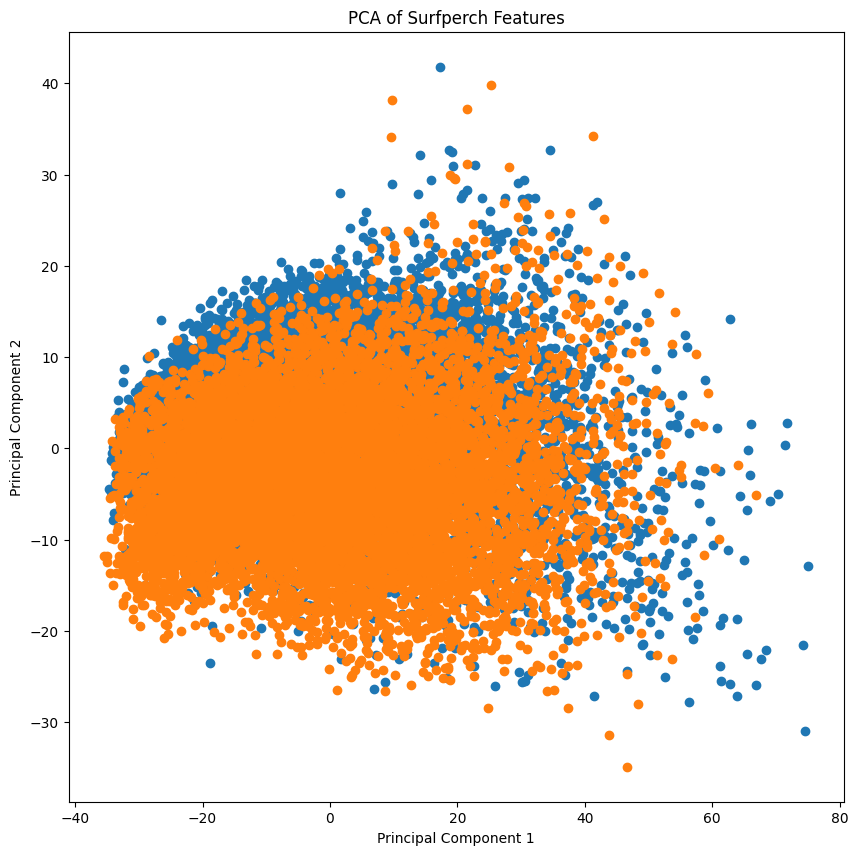

In [ ]:
#Using the above dataframe with metadata:
metadata = features_metadata_df[['filename', 'embedding_index', 'Class', 'Recorder_ID', 'Site']]
features = features_metadata_df.drop(['filename', 'embedding_index', 'Class', 'Recorder_ID', 'Site'], axis=1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 10))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Surfperch Features')

classes = features_metadata_df['Class'].unique()  # Get unique class labels
colors = plt.cm.get_cmap('tab10')(np.arange(len(classes)) % len(classes))  # Generate colors

for i, class_label in enumerate(classes):
    class_data = principal_components[metadata['Class'] == class_label]
    plt.scatter(class_data[:, 0], class_data[:, 1], label=class_label, c=colors[i])

plt.show()

In [ ]:
#Generate Standard UMAP plots
n_neighbors = 10 # adjust for new dataset, explore more "sensible" n neighbors to assess if more discrete clusters form (they'd reflect recorder specificity), n between 10 and 15 seems ideal
min_dist = 0.1 # adjust for new dataset

#Set the seed for reproducibility
reducer = umap.UMAP(random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)

#Perform the dimensionality reduction (assuming features start from the 6th column, but we count up from 0 in the function!)
umap_embeddings = reducer.fit_transform(features_metadata_df.iloc[:, 5:])

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


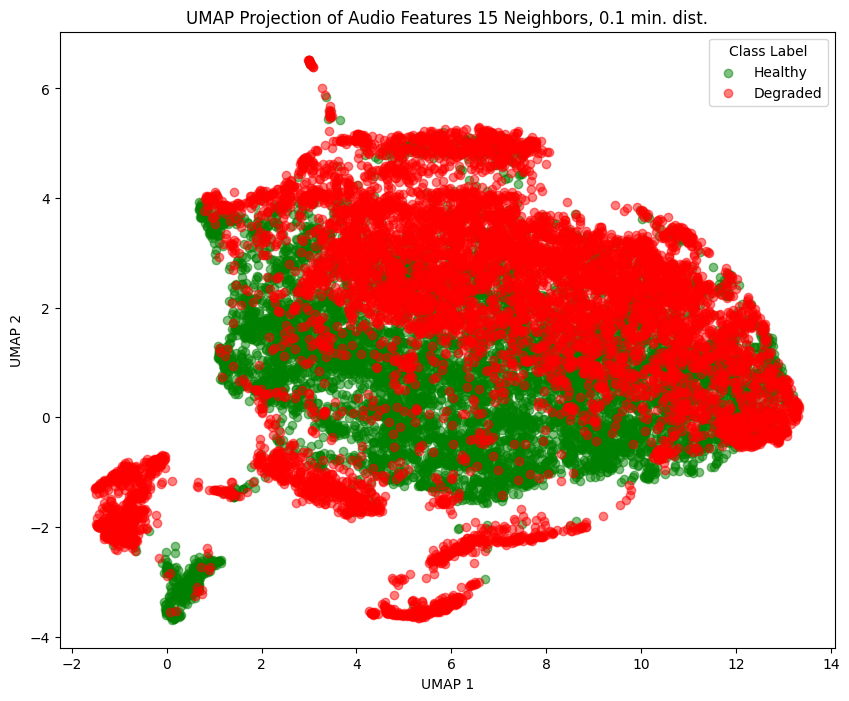

<Figure size 640x480 with 0 Axes>

In [ ]:
#Mapping from single letters to words for descriptive labels
class_mapping = {'Healthy': 'Healthy', 'Degraded': 'Degraded'}
recorder_mapping = {'249BC30461CB7108': '1', '24F3190361CB64DD': '2', '24A04F0861CB7239': '3', '249BC30461CB6536': '4', '24F3190361CB6A83': '5'}
color_mapping_class = {'Healthy': 'green', 'Degraded': 'red'}

#Set up the plot, modify the inches (10 x 8) if needed
plt.figure(figsize=(10, 8))

#Plot each class with its own color and label using the mapping
for class_type, label in class_mapping.items():
    # Select only data rows with the current class_type, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['Class'] == class_type
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=label,
                color=color_mapping_class[label], alpha=0.5)  # Assigning specific colors

plt.title('UMAP Projection of Audio Features 15 Neighbors, 0.1 min. dist.')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class Label')  # Adds a legend with a title
plt.show()

#Save the figure in a folder (Edit file path)
plt.savefig('/content/drive/MyDrive/UCL /Cluster_Model_Outputs/UMAP_Features_color_by_class.png')


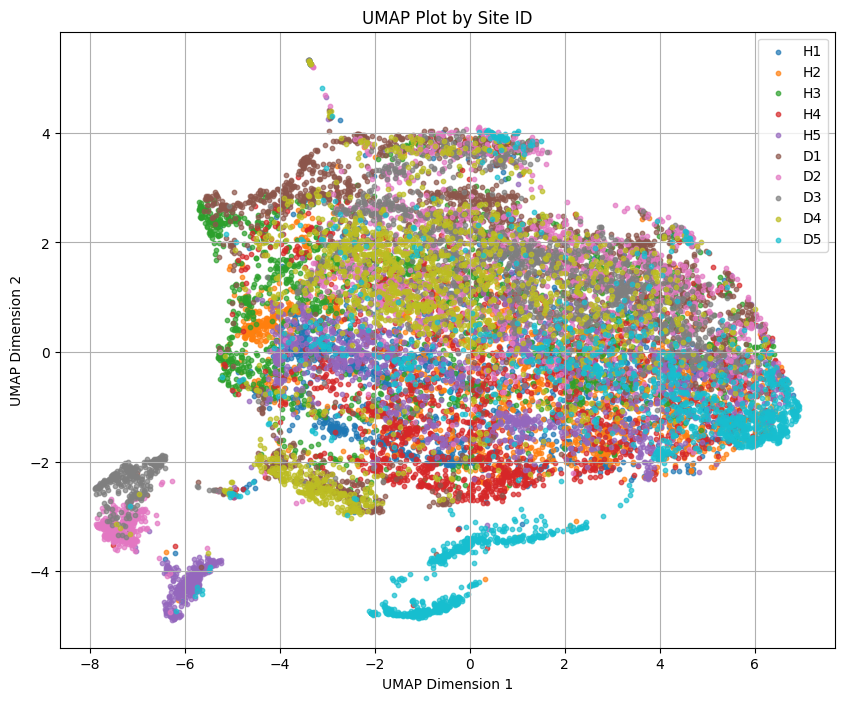

In [ ]:
# Mapping from single letters to words for descriptive labels
site_mapping = {'GoodControl3': 'H1', 'GoodControl2': 'H2', 'KecilHealthy': 'H3', 'GosongHealthyNorth': 'H4', 'GosongHealthy2': 'H5' , 'KecilDegraded': 'D1', ' NorthCentralWestSector': 'D2', 'SailisiBDegradedCES': 'D3', 'BesarSES': 'D4', 'DegradedGosong': 'D5'}
site_mapping_class = {'GoodControl3': 'green', 'GoodControl2': 'blue', 'KecilHealthy': 'yellow', 'GosongHealthyNorth': 'orange', 'GosongHealthy2': 'beige' , 'KecilDegraded': 'red', ' NorthCentralWestSector': 'pink', 'SailisiBDegradedCES': 'violet', 'BesarSES': 'black', 'DegradedGosong': 'gray'}


# Calculate the center of the UMAP plot
center_x = umap_embeddings[:, 0].mean()
center_y = umap_embeddings[:, 1].mean()

# Set up the plot, modify the inches (10 x 8) if needed
plt.figure(figsize=(10, 8))

# Plot each recorder with its own color and label using the mapping
for site_type, label in site_mapping.items():
    # Select only data rows with the recorder ID, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['Site'] == site_type
    color = site_mapping.get(label, 'gray')
    plt.scatter(umap_embeddings[indices, 0] - center_x, umap_embeddings[indices, 1] - center_y,
                label=label,s=10, alpha=0.7)  # Adjust s for point size, alpha for transparency

# Customize plot appearance
plt.grid(True)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot by Site ID')
plt.legend()

plt.show()

# Save the figure in a folder as csv (Edit file path)
#plt.savefig('/content/drive/MyDrive/UCL /Cluster_Model_Outputs/UMAP_Features_color_by_site_ID.png')

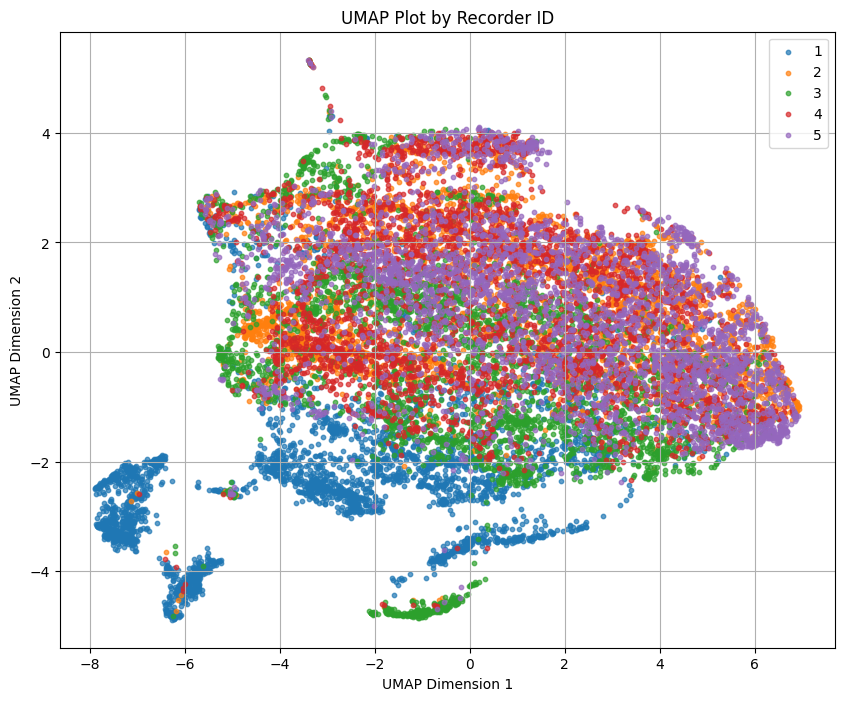

In [ ]:
# Mapping from single letters to words for descriptive labels
class_mapping = {'Healthy': 'Healthy', 'Degraded': 'Degraded'}
recorder_mapping = {'249BC30461CB7108': '1', '24F3190361CB64DD': '2', '24A04F0861CB7239': '3', '249BC30461CB6536': '4', '24F3190361CB6A83': '5'}
color_mapping_recorder = {'249BC30461CB7108': 'red', '24F3190361CB64DD': 'orange', '24A04F0861CB7239': 'yellow', '249BC30461CB6536': 'blue', '24F3190361CB6A83': 'violet'}

# Calculate the center of the UMAP plot
center_x = umap_embeddings[:, 0].mean()
center_y = umap_embeddings[:, 1].mean()

# Set up the plot, modify the inches (10 x 8) if needed
plt.figure(figsize=(10, 8))

# Plot each recorder with its own color and label using the mapping
for recorder_type, label in recorder_mapping.items():
    # Select only data rows with the recorder ID, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['Recorder_ID'] == recorder_type
    color = recorder_mapping.get(label, 'gray')
    plt.scatter(umap_embeddings[indices, 0] - center_x, umap_embeddings[indices, 1] - center_y,
                label=label,s=10, alpha=0.7)  # Adjust s for point size, alpha for transparency

# Customize plot appearance
plt.grid(True)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot by Recorder ID')
plt.legend()

plt.show()

# Save the figure in a folder as csv (Edit file path)
#plt.savefig('/content/drive/MyDrive/UCL /Cluster_Model_Outputs/UMAP_Features_color_by_Recorder_ID.png')


## What are we seeing?

The UMAP plot shows us a few key things:
1. "Each point represents a 5s audio clip. The first thing we're seing is that soundscape data is noisy, there's a lot of overlap!
2. However, if you look more closely you can see most healthy and degraded recordings clearly diverge from one another."
3. Though recordings from most devices overlap, they are not randomly distributed.
4. The here is some overlap and a significant distinction in recordings from device 1 and the other devices.
4. This may be because of one site or several sites in a similar region.

# **Step 3: Clustering**

Now we are going to perform unsupervised clustering on our dimension reduced data. We'll compare several methods including:
* k-means clustering.
* hbdscan
* clustering by affinity

Rephrase Ben's wording "SurfPerch outputs feature embeddings that are 1279 dimensions long. This is quite a lot of features to put into simple classification or clustering algorithms. Dimensionality reduction can help compress these, reducing noise and merging correlated features. We're going to reduce the dimensions by a factor of 40, down to 32. We will use UMAP to do this once again."

Then we will perform clustering using the resulting reduced embeddings.




In [ ]:
#Dimensionality reduction with UMAP

# TODO Number of dimensions to be output by UMAP, fiddle with this (was 32, then 2)
n_dims = 2

# n_neighbors and min_dist are important parameters, but we can use common defaults
reducer = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, random_state = random_seed, n_components = n_dims)

# Perform the dimensionality reduction (assuming features start from the 6th column, but we count up from 0 in the function!)
umap_embedding2 = reducer.fit_transform(features_metadata_df.iloc[:, 5:])



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


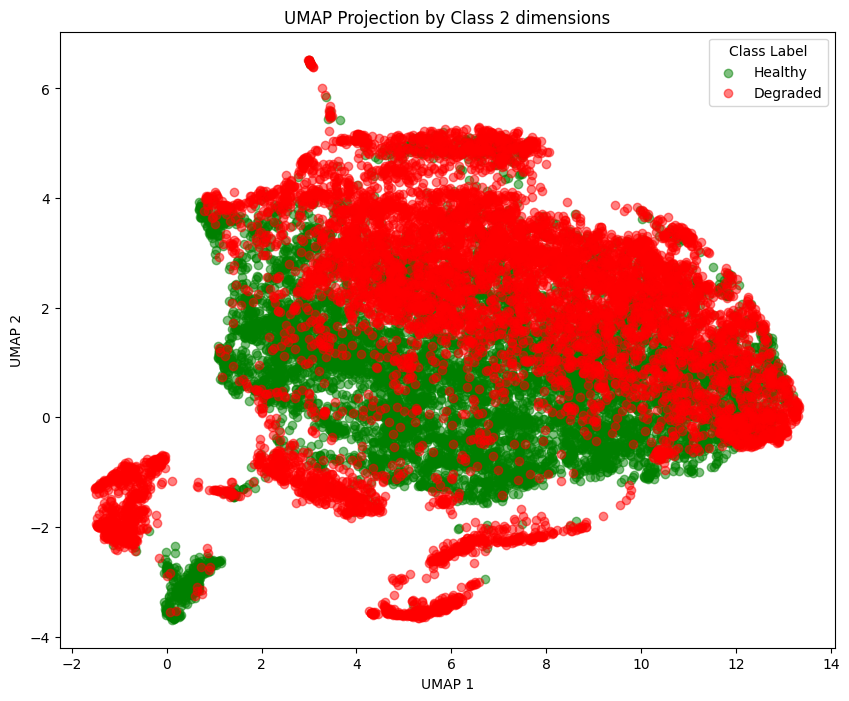

In [ ]:

# Mapping from single letters to words for descriptive labels
class_mapping2 = {'Healthy': 'Healthy', 'Degraded': 'Degraded'}
recorder_mapping2 = {'249BC30461CB7108': '1', '24F3190361CB64DD': '2', '24A04F0861CB7239': '3', '249BC30461CB6536': '4', '24F3190361CB6A83': '5'}
color_mapping_class2 = {'Healthy': 'green', 'Degraded': 'red'}

#Set up the plot, modify the inches (10 x 8) if needed
plt.figure(figsize=(10, 8))

#Plot each class with its own color and label using the mapping
for class_type2, label in class_mapping2.items():
    # Select only data rows with the current class_type, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['Class'] == class_type2
    plt.scatter(umap_embedding2[indices, 0], umap_embedding2[indices, 1], label=label,
                color=color_mapping_class2[label], alpha=0.5)  # Assigning specific colors

plt.title('UMAP Projection by Class 2 dimensions')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class Label')  # Adds a legend with a title
plt.show()

#Add 2 columns for UMAP dimensions 1 and 2 into the dataframe. We will create a mixed effects model from this csv file on R Studio.
features_metadata_df.loc[:, 'UMAP 1'] = umap_embedding2[:, 0]  # Access first column
features_metadata_df.loc[:, 'UMAP 2'] = umap_embedding2[:, 1]

#Arrange columns in desired order. -currently truncating the dataframe grrr
column_order = ['filename', 'UMAP 1', 'UMAP 2'] + \
               [col for col in features_metadata_df.columns if any(col.startswith(prefix) for prefix in ['embedding_index', 'Class', 'Recorder_ID', 'Site','feature_' ])]
features_metadata_df_umap = features_metadata_df[column_order]

In [ ]:
#Take a look
features_metadata_df_umap

features_metadata_df_umap.to_csv(features_metadata_umap_path, index=False)



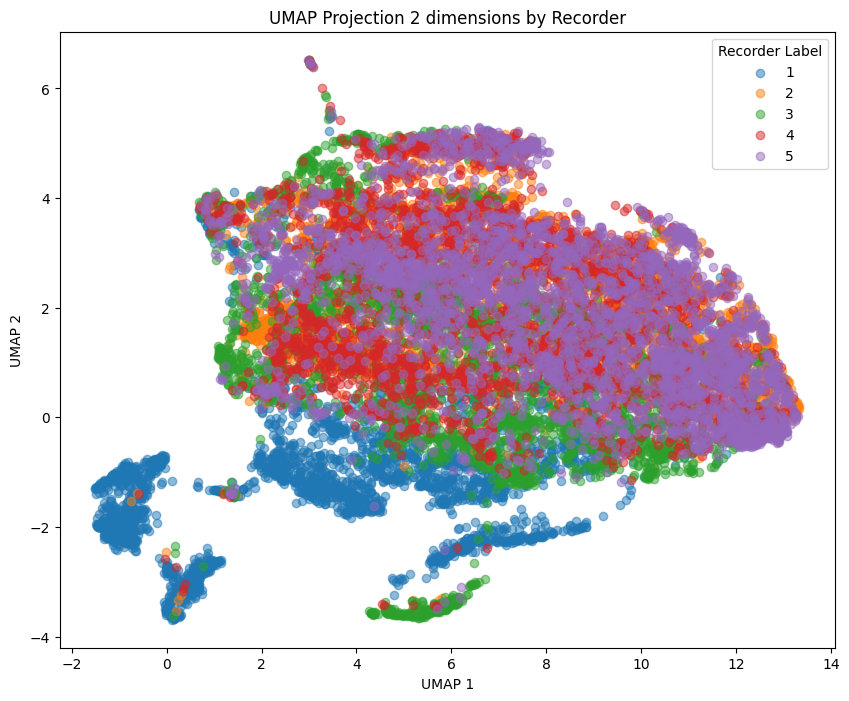

In [ ]:
# Mapping from single letters to words for descriptive labels
class_mapping2 = {'Healthy': 'Healthy', 'Degraded': 'Degraded'}
recorder_mapping2 = {'249BC30461CB7108': '1', '24F3190361CB64DD': '2', '24A04F0861CB7239': '3', '249BC30461CB6536': '4', '24F3190361CB6A83': '5'}
color_mapping_recorder = {'249BC30461CB7108': 'red', '24F3190361CB64DD': 'orange', '24A04F0861CB7239': 'yellow', '249BC30461CB6536': 'blue', '24F3190361CB6A83': 'violet'}

# Set up the plot, modify the inches (10 x 8) if needed
plt.figure(figsize=(10, 8))

# Plot each recorder with its own color and label using the mapping
for recorder_type2, label in recorder_mapping2.items():
    # Select only data rows with the current class_type, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['Recorder_ID'] == recorder_type2
    plt.scatter(umap_embedding2[indices, 0], umap_embedding2[indices, 1], label=label, alpha=0.5)  # Assigning specific colors

plt.title('UMAP Projection 2 dimensions by Recorder')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Recorder Label')  # Adds a legend with a title
plt.show()

In [ ]:
#Create filepath for cluster results
cluster_results_kmeans = '/content/drive/MyDrive/UCL /Cluster_Model_Outputs/cluster_results_kmeans.csv'

In [ ]:
# Copy the original DataFrame to preserve the original data
cluster_results_kmeans = features_metadata_df.copy()

# Set variables, justify number
num_clusters = 10

# Assuming umap_embeddings is a NumPy array or Pandas DataFrame
kmeans = KMeans(n_clusters=num_clusters, random_state=random_seed)
clusters = kmeans.fit_predict(umap_embedding2)

# Add the cluster information to the new DataFrame
cluster_results_kmeans['cluster'] = clusters

#Silhouette scores
silhouette_avg = silhouette_score(umap_embedding2, clusters)
print("Silhouette Coefficient:", silhouette_avg)

# Save and view the results
cluster_results_kmeans.to_csv('/content/drive/MyDrive/UCL /Cluster_Model_Outputs/cluster_results_kmeans.csv', index=False)
print(cluster_results_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Coefficient: 0.38654965
                                                filename  embedding_index  \
0      M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...                1   
1      M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...                2   
2      M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...                3   
3      M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...                4   
4      M14_SD1_SailisiBDegradedCES_ 24F3190361CB64DD_...                5   
...                                                  ...              ...   
17045  M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...                7   
17046  M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...                8   
17047  M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...                9   
17048  M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...               10   
17049  M14_SD6_SailisiBDegradedCES_249BC30461CB7108_2...               11   

          Class       Recorder_ID       

## View results

The `cluster_results_kmeans` dataframe has now been saved to the results folder in your GDrive. We will now visualise the clustering results by class, site, and recorder ID which we call micro-site.

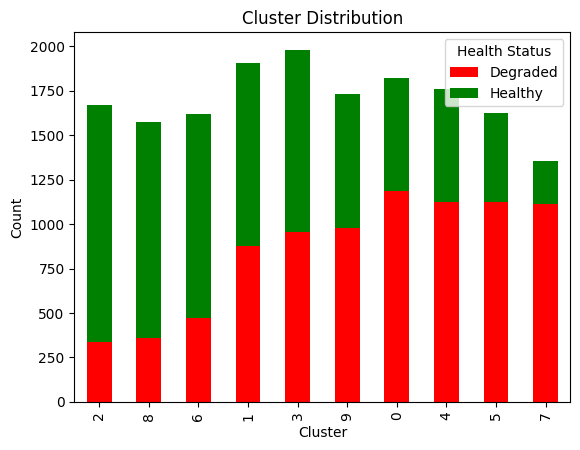

In [ ]:
# Group by 'cluster' and 'class_type', and count occurrences
cluster_class_counts = cluster_results_kmeans.groupby(['cluster', 'Class']).size().unstack().fillna(0)

# Check if 'Healthy' exists as a column before sorting
if 'Healthy' in cluster_class_counts.columns:
  # Sort by count of 'Healthy' in descending order within the DataFrame
  cluster_class_counts = cluster_class_counts.sort_values(by='Healthy', ascending=False)

# Create the bar plot
cluster_class_counts.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.legend(title='Health Status')
plt.show()

## What are we seeing?

The cluster results were saved to a table `cluster_results_kmeans` which I will remind you has data from 10 sites.

So far: Healthy and degraded reefs are clustered distinctively with little overlap. Treatment level differences are assumed to be highly significant.

Let's repeat clustering using the other techniques mentioned, hbdscan and clustering by affinity. Briefly explain why it makes more sense to start from existing datapoints as central node.

Later we will  examine how clustering occurs between sites of a given class, and across classes.

Then we'll examine clustering by recorder ID.


##Cluster then Visualize with HDBSCAN

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Silhouette Coefficient: 0.26316896


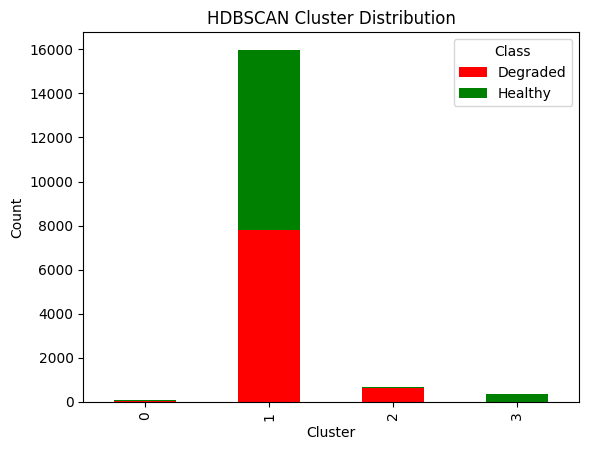

In [ ]:
#Create filepath for cluster results
cluster_results_fullhdbscan = '/content/drive/MyDrive/UCL /Cluster_Model_Outputs/Cluster_by_Class_hdbscan.csv'

# Clustering with hdbscan
# Copy the original DataFrame to preserve the original data
cluster_results_fullhdbscan = features_metadata_df.copy()

#Cluster with hbdscan. The minimum cluster size is the min. number of datapoints in a cluster
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True)  # Adjust parameters as needed
clusters = clusterer.fit_predict(umap_embedding2)

# Add cluster labels to the DataFrame. We add +1 because our columns are numbered from 0 onwards, making matplot assign 0 to -1
cluster_results_fullhdbscan['cluster'] = clusters + 1

# Group by 'cluster' and 'Class', count occurrences, and fill missing values
cluster_class_counts = (
    cluster_results_fullhdbscan.groupby(['cluster', 'Class'])
    .size()
    .unstack()
    .fillna(0)
)

#Silhouette scores
silhouette_avg = silhouette_score(umap_embedding2, clusters)
print("Silhouette Coefficient:", silhouette_avg)

# Create the stacked bar plot
cluster_class_counts.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('HDBSCAN Cluster Distribution')
plt.legend(title='Class')
plt.show()


# Save and view the results
cluster_results_fullhdbscan.to_csv('/content/drive/MyDrive/UCL /Cluster_Model_Outputs/Cluster_by_Class_BarPlot_hdbscan.csv', index=False)

In [ ]:
#Perform linkage analysis to create a hierarchical representation
linkage_matrix = sch.linkage(umap_embedding2, method='ward')  # Adjust method as needed

#Create the dendrogram
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
dendrogram = sch.dendrogram(linkage_matrix, labels='Class', leaf_rotation=90)  #Assign label from class to site and microsite + Rotate labels for readability

#Get cluster cuts (optional, for identifying cluster thresholds)
#threshold = 3  # Adjust threshold value for desired cluster granularity
#cluster_cuts = sch.cut(linkage_matrix, threshold)

plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram (HDBSCAN Results)")
plt.show()

ValueError: Dimensions of Z and labels must be consistent.

<Figure size 1000x800 with 0 Axes>

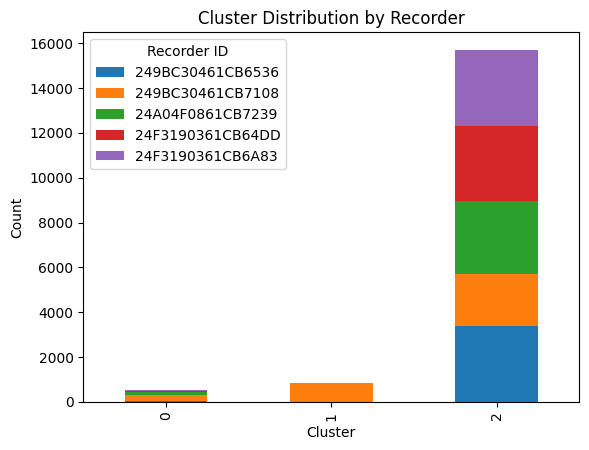

In [ ]:
#Create filepath for cluster results
cluster_results_hdbscan_rec = '/content/drive/MyDrive/UCL /Cluster_Model_Outputs/Cluster_by_Class_BarPlot_hdbscan_by_recorder.png'

# Clustering with hdbscan
# Copy the original DataFrame to preserve the original data
cluster_results_hdbscan_rec = features_metadata_df.copy()

#Cluster with hbdscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, gen_min_span_tree=True)  # Adjust parameters as needed
clusters = clusterer.fit_predict(umap_embeddings)

# Add cluster labels to the DataFrame. We add +1 because our columns are numbered from 0 onwards, making matplot assign 0 to -1
cluster_results_hdbscan_rec['cluster'] = clusters + 1

# Group by 'cluster' and 'Class', count occurrences, and fill missing values
cluster_recorder_counts = (
    cluster_results_fullhdbscan.groupby(['cluster', 'Recorder_ID'])
    .size()
    .unstack()
    .fillna(0)
)

# Create the stacked bar plot
cluster_recorder_counts.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution by Recorder')
plt.legend(title='Recorder ID')
plt.show()


# Save and view the results
cluster_results_fullhdbscan.to_csv('/content/drive/MyDrive/UCL /Cluster_Model_Outputs/Cluster_by_Class_BarPlot_hdbscan.csv', index=False)

In [ ]:
#Add this to each clustered results before Silhouette scores:
# Calculate the silhouette score
silhouette_avg = silhouette_score(umap_embeddings, clusters)

# Print the average silhouette score
print("Average Silhouette Score:", silhouette_avg)

SyntaxError: invalid syntax (<ipython-input-20-104ecec35bc6>, line 1)

## Clustering by Affinity Propagation and visualization

In [ ]:
# Assuming umap_embeddings is a NumPy array or Pandas DataFrame
#need to install something that does affinity propagation
affinity_prop = AffinityPropagation(damping=0.5) # Adjust damping parameter as needed
clusters = affinity_prop.fit_predict(umap_embedding2)  # Perform clustering; Taking a boatload of time, reproduce with small dataset

# Add cluster labels to the DataFrame, maybe add 1 since columns start at 0
cluster_results['cluster'] = clusters

# Group by 'cluster' and 'Class', count occurrences, and fill missing values
cluster_class_counts_affinity = (
    cluster_results.groupby(['cluster', 'Class'])
    .size()
    .unstack()
    .fillna(0)
)

# Create the stacked bar plot
cluster_class_counts_affinity.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.legend(title='Health Status')
plt.show()

KeyboardInterrupt: 

# **Step 4: Principal Component Analysis**

In [ ]:
#Principal Component Analysis


# **Conclusions**

The two notebooks presented here for 'Feature Extraction' and 'Unsupervised Learning' present a foundation to be adapted for new soundscape work using an example dataset.

You can now try this on your own data by uploading it to GDrive. You can modify this code or try and stick to its current form by mimicing the folder structure and naming format of our data. The feature extraction should run smoothly if this is done. Unsupervised analysis may require further modification for your use case if it differs significantly.

